In [1]:
from setup.voxel_setup import setup_voxel_scene
from simulation.simulator import compute_ior_gradient, generate_initial_wavefront, simulate_wavefront_propagation, remove_under_floor
from common.plot import Plotter
from data.octree import Octree
from data.mlp import MLP
from data.np_grid import *
import taichi as ti
from scipy import ndimage

# debug=True to check boundary access
ti.init(arch=ti.gpu)

%load_ext autoreload
%autoreload 2

# Commented because the compatibility of this extension is not good
%matplotlib widget 

[Taichi] version 1.7.1, llvm 15.0.1, commit 0f143b2f, win, python 3.11.9
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Taichi] Starting on arch=cuda


Step 0, Total loss 0.241252


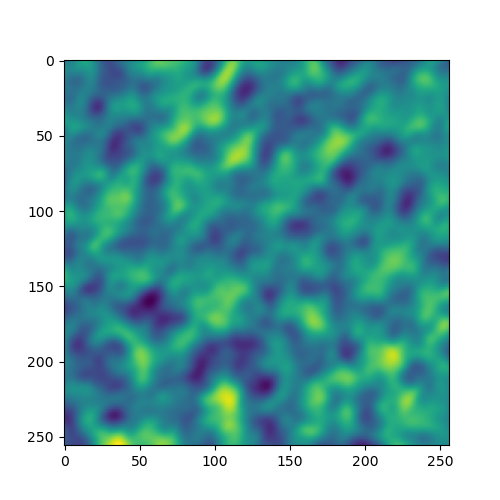

Step 100, Total loss 0.015535


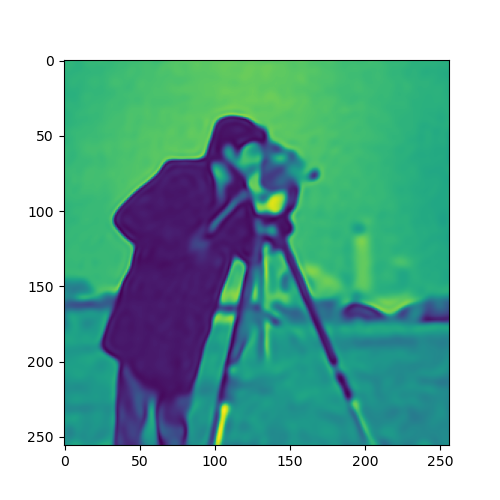

Step 200, Total loss 0.008258


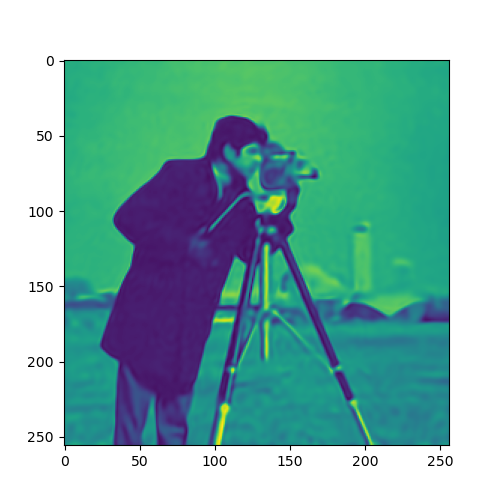

Step 300, Total loss 0.004593


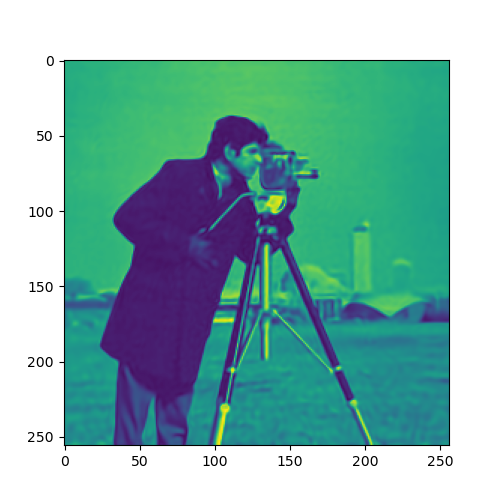

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
from data.siren import *


cameraman_img = Image.open("cameraman.jpg").convert("L")

cameraman = ImageFitting(cameraman_img, 256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

img_siren = Siren(in_features=2, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True)
img_siren.cuda()

total_steps = 400 # Since the whole image is our dataset, this just means 500 gradient descent steps.
steps_til_summary = 100

optim = torch.optim.Adam(lr=1e-4, params=img_siren.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

for step in range(total_steps):
    model_output = img_siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()

    if not step % steps_til_summary:
        print("Step %d, Total loss %0.6f" % (step, loss))
        # img_grad = gradient(model_output, coords)
        # img_laplacian = laplace(model_output, coords)

        plt.figure(figsize=(5,5))
        plt.imshow(model_output.cpu().view(256,256).detach().numpy())
        plt.show()

    optim.zero_grad()
    loss.backward()
    optim.step()

## 1. Load voxel model

In [3]:
NUM_XYZ = (128, 128, 128)
scene, floor_height = setup_voxel_scene(*NUM_XYZ)

Loaded Voxel shape: (128, 128, 128)  from: ./assets/bun_zipper_res4.ply
Number of filled voxels: 13849
Loaded Voxel shape: (128, 128, 128)  from: ./assets/wine_glass.obj
Number of filled voxels: 9035
Floor Ratio: -0.3125 , Floor Height: 44


## 2. Path tracing render

In [4]:
# scene.finish()

## 3. Perform light simulation

[ Loaded ] irradiance and local direction from c:\Users\yaozi\Desktop\Voxel-Render\data\saves\NP(irrad,loc_dir)(3-samplers).npz


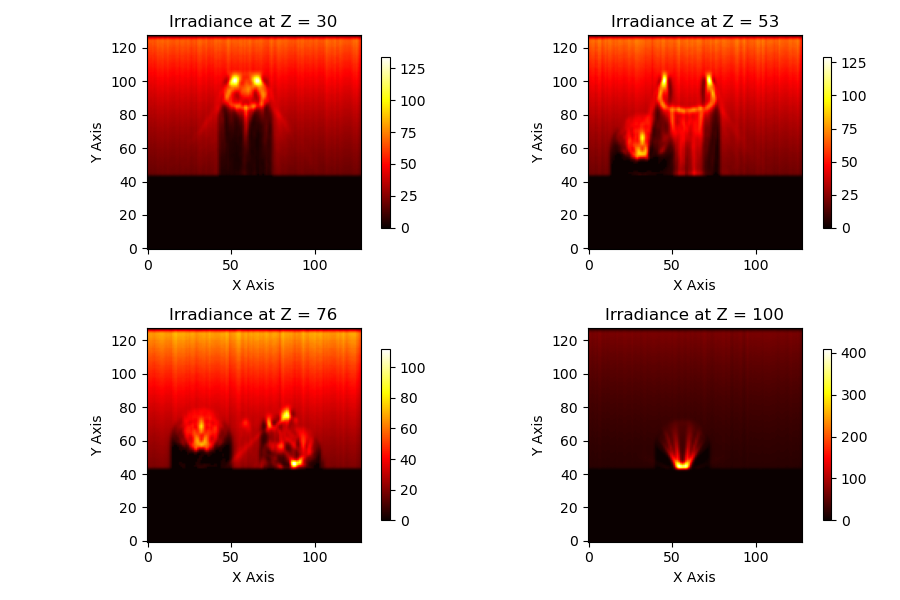

In [5]:
assert scene.ior.shape == NUM_XYZ, "The scene IOR should be a NumPy array of shape (NUM_X, NUM_Y, NUM_Z)"

sampler_multiplier = 3
pos_perturbation_scale = 0.45
initial_wavefront_pos, initial_wavefront_dir = generate_initial_wavefront(sampler_multiplier, pos_perturbation_scale, *NUM_XYZ)

scene.ior = ndimage.gaussian_filter(scene.ior, sigma=3.0, radius=1)
scene.gradient = compute_ior_gradient(scene.ior)

plotter = Plotter(sampler_multiplier, floor_height, scene.ior)
# plotter.plot_wavefront_position(initial_wavefront_pos, initial_wavefront_dir, title="Initial Wavefront Positions")
# plotter.plot_gradient(scene.gradient, threshold=0.01, alpha=0.01)
load = True
if load and irrad_loc_dir_save_exists(sampler_multiplier):
    raw_irradiance, scene.local_diretion = load_irrad_loc_dir(sampler_multiplier)    
else:
    step_size = 0.3 * (NUM_XYZ[1] / 100)
    num_steps = int(1.0 * (NUM_XYZ[1]  / step_size))
    num_show_images = 0
    raw_irradiance, scene.local_diretion = simulate_wavefront_propagation(scene.ior, scene.gradient, scene.attenuation,
                                                    initial_wavefront_pos, initial_wavefront_dir,
                                                    plotter, num_steps, step_size, num_show_images)
    save_irrad_loc_dir(raw_irradiance, scene.local_diretion, sampler_multiplier)

raw_irradiance = remove_under_floor(raw_irradiance, floor_height=floor_height)
scene.irradiance = ndimage.gaussian_filter(raw_irradiance, sigma=0.8) 
# plotter.plot_irradiance_slices(raw_irradiance, threshold=3, num_slices=4, z_start=30, z_end=100)
plotter.plot_irradiance_slices(scene.irradiance, threshold=3, num_slices=4, z_start=30, z_end=100)

In [6]:
# from data.siren import *

# siren = SirenIrradiance(scene.irradiance, floor_height, NUM_XYZ, sampler_multiplier=sampler_multiplier,
#                         in_features=3, out_features=1, hidden_features=256, hidden_layers=3, outermost_linear=True,
#                         num_epoches=400)

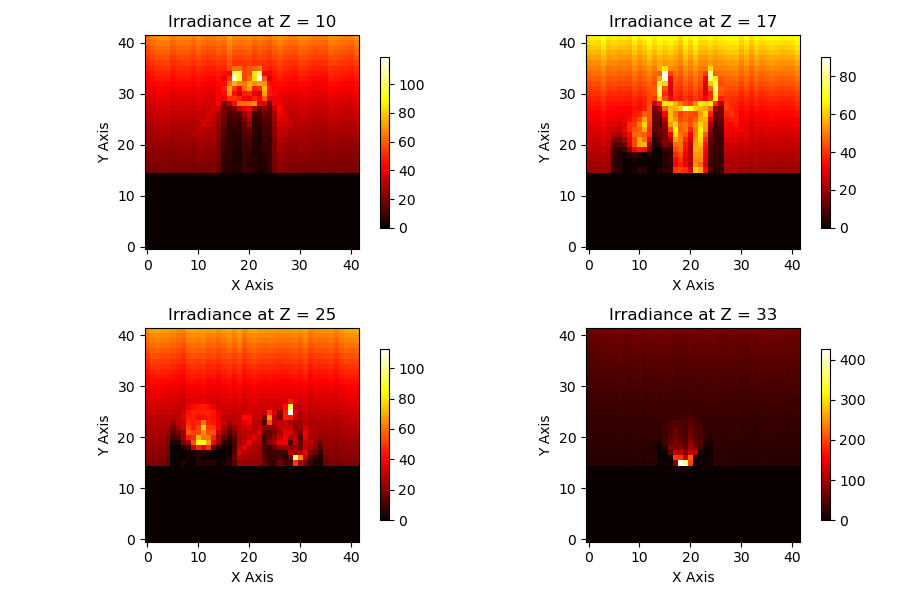

(42, 42, 42)


In [7]:
target_size = 42
compress_factor = 128 // target_size

# 使用数组切片提取所需的元素
sliced_arr = scene.irradiance[::compress_factor, ::compress_factor, ::compress_factor]

# 使用数组重塑将切片后的数组调整为目标尺寸
compressed_arr = sliced_arr[:target_size, :target_size, :target_size]
plotter.plot_irradiance_slices(compressed_arr, threshold=3, num_slices=4, z_start=30/compress_factor, z_end=100/compress_factor)

print(compressed_arr.shape)

In [27]:
from data.siren import *
torch.cuda.empty_cache()


irrad_data = VoxelFitting(compressed_arr, sidelength=compressed_arr.shape[0])
dataloader = DataLoader(irrad_data, batch_size=1, pin_memory=True)
siren = Siren(in_features=3, out_features=1, hidden_features=256,
                  hidden_layers=3, outermost_linear=True,
                  first_omega_0=5, hidden_omega_0=5)
siren.cuda()

total_steps = 2000
steps_til_summary = 100

optim = torch.optim.Adam(lr=2e-3, params=siren.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.2, patience=10)
        
model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.cuda(), ground_truth.cuda()

siren.train()
for cur_step in range(total_steps):
    model_output = siren(model_input)
    loss = ((model_output - ground_truth)**2).mean()
    scheduler.step(loss)

    if not cur_step % steps_til_summary:
        print("Step: {} \tloss: {:.4f} \tLearning Rate: {}".format(cur_step, loss, scheduler.get_last_lr()))

    optim.zero_grad()
    loss.backward()
    optim.step()


Step: 0 	loss: 4825.6387 	Learning Rate: [0.002]
Step: 100 	loss: 1407.4316 	Learning Rate: [0.002]
Step: 200 	loss: 589.6957 	Learning Rate: [0.002]
Step: 300 	loss: 357.7410 	Learning Rate: [0.002]
Step: 400 	loss: 269.9224 	Learning Rate: [0.002]
Step: 500 	loss: 230.0821 	Learning Rate: [0.002]
Step: 600 	loss: 212.0910 	Learning Rate: [0.002]
Step: 700 	loss: 200.9834 	Learning Rate: [0.0004]
Step: 800 	loss: 198.4830 	Learning Rate: [0.0004]
Step: 900 	loss: 196.0512 	Learning Rate: [0.0004]
Step: 1000 	loss: 193.6780 	Learning Rate: [0.0004]
Step: 1100 	loss: 191.3712 	Learning Rate: [0.0004]
Step: 1200 	loss: 189.1300 	Learning Rate: [0.0004]
Step: 1300 	loss: 186.9482 	Learning Rate: [0.0004]
Step: 1400 	loss: 184.8203 	Learning Rate: [0.0004]
Step: 1500 	loss: 182.7382 	Learning Rate: [0.0004]
Step: 1600 	loss: 180.6854 	Learning Rate: [0.0004]
Step: 1700 	loss: 178.6398 	Learning Rate: [0.0004]
Step: 1800 	loss: 176.7636 	Learning Rate: [0.0004]
Step: 1900 	loss: 174.5330 	L

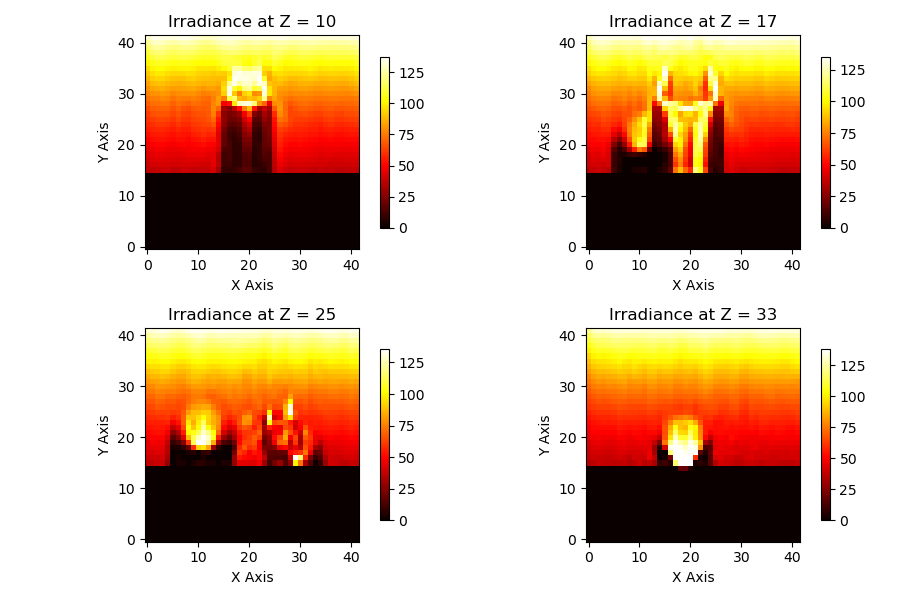

In [28]:
result = model_output.cpu().view(compressed_arr.shape).detach().numpy()
new_res = np.transpose(result, (1, 2, 0))
plotter.plot_irradiance_slices(new_res, threshold=3, num_slices=4, z_start=30/compress_factor, z_end=100/compress_factor)

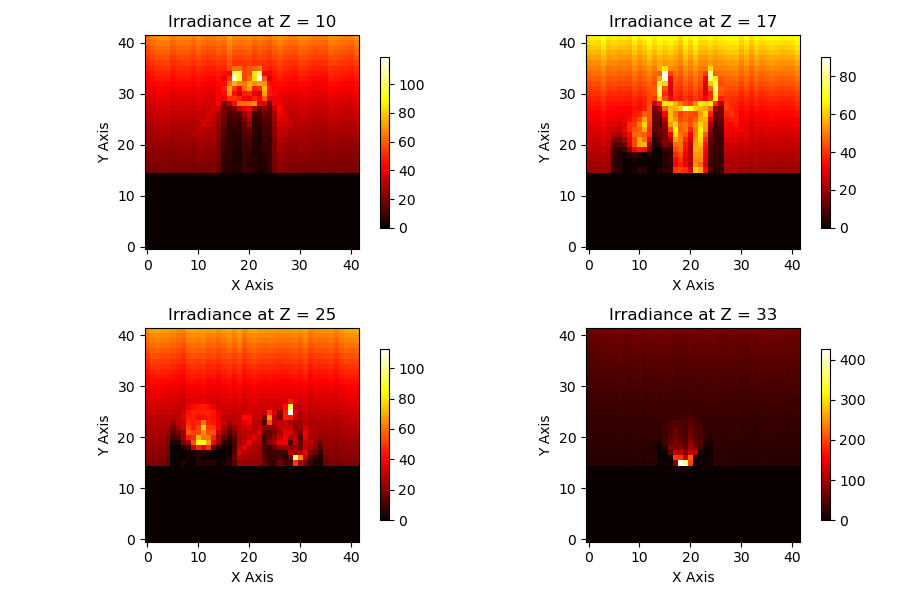

In [23]:
ground_truth_arr = ground_truth.cpu().view(compressed_arr.shape).detach().numpy()
ground_truth_arr_res = np.transpose(ground_truth_arr, (1, 2, 0))
plotter.plot_irradiance_slices(ground_truth_arr_res, threshold=3, num_slices=4, z_start=30/compress_factor, z_end=100/compress_factor)

## 4. Store irradiance in Neural network irradiance （MLP）

In [ ]:
mlp = MLP(scene.irradiance, floor_height, NUM_XYZ, sampler_multiplier=sampler_multiplier, num_epoches=30)

In [ ]:
# Visualize the predicted irradiance field
predicted_irradiance = mlp.predict(pad=True)
plotter.plot_irradiance_slices(predicted_irradiance.cpu().numpy(), threshold=3, 
                               num_slices=4, z_start=30, z_end=100)

## 5. SIREN

## 5. Store irradiance in octree

In [ ]:
octree = Octree(threshold=int(0.6 * (sampler_multiplier**3)))
octree.construct(scene.irradiance)
print(f"Number of nodes: {len(octree)}")
print(f"Octree Memory usage: {octree.__sizeof__()} bytes")
print(f"In comparison, NumPy Storage Usage: {scene.irradiance.nbytes} bytes")
octree.visualize(plotter, num_slices=4, z_start=30, z_end=100)

In [ ]:
x, y, z = 60, 60, 60
value = octree.query(x, y, z)
value

## 6. Ray marching render